In [1]:
import sys,os
import pandas as pd
import numpy as np
#import matplotlib
#import matplotlib.pyplot as plt 
import seaborn as sns
from math import isnan
#%matplotlib inline

In [2]:
d_accident=pd.read_csv('NYPD_Motor_Vehicle_Collisions.csv')
print d_accident.shape

(695735, 29)


In [3]:
d_accident.head(1)

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,11/09/2015,19:00,QUEENS,11419,40.688112,-73.819331,"(40.6881124, -73.8193308)",LIBERTY AVENUE,125 STREET,NaN,...,Unspecified,NaN,NaN,NaN,3332027,VAN,PASSENGER VEHICLE,NaN,NaN,NaN


In [4]:
type_grouped = d_accident.groupby('VEHICLE TYPE CODE 1')
#type_grouped.head(5)
#d_accident["LATITUDE"]

# Найдем топ-5 самых опасных для велосипедистов улиц:

In [5]:
def bicycle_warning(d_accident):
    dangerous_streets = dict()
    total_accident = 0
    
    for item, row in d_accident.iterrows():
        if (row['VEHICLE TYPE CODE 1'] == "BICYCLE") or (row['VEHICLE TYPE CODE 2'] == "BICYCLE") or (row['VEHICLE TYPE CODE 3'] == "BICYCLE") or (row['VEHICLE TYPE CODE 4'] == "BICYCLE") or (row['VEHICLE TYPE CODE 5'] == "BICYCLE"):
            total_accident += 1
            if row["ON STREET NAME"] in dangerous_streets:
                dangerous_streets[row["ON STREET NAME"]] += 1
            else:
                dangerous_streets[row["ON STREET NAME"]] = 1
           
    top_dangerous = sorted(dangerous_streets.items(), key=lambda street: street[1], reverse=True)
    print total_accident
    for key, value in top_dangerous[:6]:    
        if not (type(key) == float and isnan(key)):
            print key, value
    
    return
    
bicycle_warning(d_accident)


17742
BROADWAY 476
5 AVENUE 242
BEDFORD AVENUE 219
ROOSEVELT AVENUE 174
3 AVENUE 163


# А теперь - топ-5 самых распостраненных причин аварий, в которые попадают таксисты:

In [6]:
def taxi_warning(d_accident):
    accident_reason = dict()
    total_accident = 0
    
    #d_accident.apply(add_street, axis=1)
    for item, row in d_accident.iterrows():
        for i in xrange(1,5):
            if row['VEHICLE TYPE CODE ' + str(i)] == "TAXI":
                total_accident += 1
                if row["CONTRIBUTING FACTOR VEHICLE " + str(i)] in accident_reason:
                    accident_reason[row["CONTRIBUTING FACTOR VEHICLE " + str(i)]] += 1
                else:
                    accident_reason[row["CONTRIBUTING FACTOR VEHICLE " + str(i)]] = 1

    accident_reason.pop('Unspecified')        
    top_reasons = sorted(accident_reason.items(), key=lambda reason: reason[1], reverse=True)
    print total_accident
    for key, value in top_reasons[:5]:    
        print key, value
    
    return
    
taxi_warning(d_accident)

54876
Driver Inattention/Distraction 5419
Other Vehicular 3281
Fatigued/Drowsy 2738
Turning Improperly 2050
Failure to Yield Right-of-Way 1709


# Выберем координаты аварий с участием таксистов:
Учитывая, что все аварии либо имеют обе координаты, либо не имеют их вообще

In [7]:
def get_coordinates(d_accident):
    lon = list()
    lat = list()
    for item, row in d_accident.iterrows():
        for i in xrange(1,5):
            if row['VEHICLE TYPE CODE ' + str(i)] == "TAXI":
                if not (type(row["LATITUDE"]) == float and isnan(row["LATITUDE"])):
                    lon.append(row["LONGITUDE"])
                    lat.append(row["LATITUDE"])
    return lon, lat

lon, lat = get_coordinates(d_accident)


# И отметим их на карте:

In [8]:
import pylab as pl
import mpl_toolkits.basemap as bm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


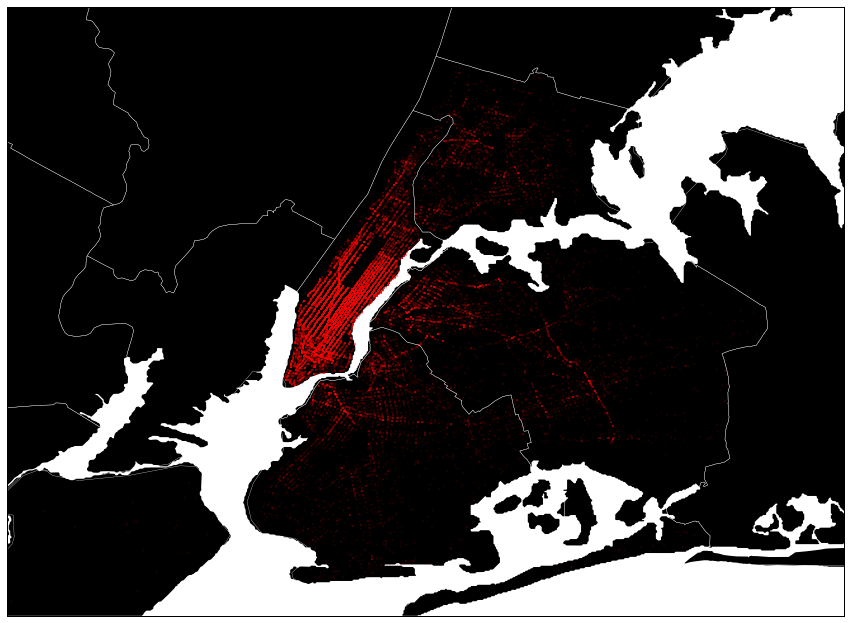

In [11]:
fig = plt.figure(figsize=(15,15))
accident_map = bm.Basemap(llcrnrlat=40.55, urcrnrlat=40.95, llcrnrlon=-74.2, urcrnrlon=-73.65, resolution='f')

accident_map.fillcontinents(color='black', zorder=0)
accident_map.drawcounties(linewidth=0.3, color='white')
accident_map.drawmapboundary(fill_color='white')

accident_map.scatter(lon, lat, color='red', s=0.1)

pl.show()

# Отобразим смертельность аварий по различным видам транспорта:

In [ ]:
def death_accidents(d_accident):  
    vehicle_types = dict()
    for item, row in d_accident.iterrows():
        for i in xrange(1,5):
            if not (type(row['VEHICLE TYPE CODE ' + str(i)]) == float and isnan(row['VEHICLE TYPE CODE ' + str(i)])):
                if row['VEHICLE TYPE CODE ' + str(i)] not in vehicle_types:
                    vehicle_types[row['VEHICLE TYPE CODE ' + str(i)]] = {'total accidents': 1, 'total deaths': row['NUMBER OF PERSONS KILLED']}
                else:
                    vehicle_types[row['VEHICLE TYPE CODE ' + str(i)]]['total accidents']  += 1
                    vehicle_types[row['VEHICLE TYPE CODE ' + str(i)]]['total deaths']  += row['NUMBER OF PERSONS KILLED']
                if row['NUMBER OF PERSONS KILLED'] not in vehicle_types[row['VEHICLE TYPE CODE ' + str(i)]]:
                    vehicle_types[row['VEHICLE TYPE CODE ' + str(i)]][row['NUMBER OF PERSONS KILLED']] = 1
                else:
                    vehicle_types[row['VEHICLE TYPE CODE ' + str(i)]][row['NUMBER OF PERSONS KILLED']] += 1

    #print vehicle_types
    
    return vehicle_types

vehicle_types = death_accidents(d_accident)

In [34]:
print vehicle_types

{'TAXI': {0L: 54849, 1L: 26, 2L: 1, 'total deaths': 28L, 'total accidents': 54876}, 'SMALL COM VEH(4 TIRES)': {0L: 23273, 1L: 11, 'total deaths': 11L, 'total accidents': 23284}, 'VAN': {0L: 45241, 1L: 45, 'total deaths': 45L, 'total accidents': 45286}, 'PEDICAB': {0L: 109, 'total deaths': 0L, 'total accidents': 109}, 'FIRE TRUCK': {0L: 1175, 1L: 1, 'total deaths': 1L, 'total accidents': 1176}, 'BUS': {0L: 23239, 1L: 46, 'total deaths': 49L, 3L: 1, 'total accidents': 23286}, 'SCOOTER': {0L: 486, 1L: 2, 'total deaths': 2L, 'total accidents': 488}, 'AMBULANCE': {0L: 2982, 1L: 1, 'total deaths': 1L, 'total accidents': 2983}, 'BICYCLE': {0L: 17750, 1L: 53, 'total deaths': 53L, 'total accidents': 17803}, 'SPORT UTILITY / STATION WAGON': {0L: 300085, 1L: 295, 2L: 11, 3L: 2, 5L: 1, 'total accidents': 300394, 'total deaths': 328L}, 'OTHER': {0L: 41452, 1L: 37, 'total deaths': 37L, 'total accidents': 41489}, 'MOTORCYCLE': {0L: 7317, 1L: 112, 2L: 4, 'total deaths': 120L, 'total accidents': 7433},

# Напечатаем средние и медианы для каждого вида транспорта:

In [ ]:
for vehicle, deaths in vehicle_types.iteritems():
    print vehicle
    average = float(vehicle_types[vehicle]['total deaths']) / float(vehicle_types[vehicle]['total accidents'])
    print 'average deaths %0.5f' % average
    #print deaths
    for key, value in deaths.iteritems():
        possibility = 0.0
        if key != 'total deaths' or key != 'total accidents':
            possibility += float(value) / float(deaths['total accidents'])
            if possibility >= 0.5:
                print 'median ' + str(key)
            break
            

    